## Modelling the dynamics of football with Markov chains

In [1464]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pydtmc as dtmc
from matplotlib import animation, rc
import gc
gc.collect()

112080

### Data Cleaning and Visualisation 

In [1360]:
# read in the data
players = pd.read_json("/Users/gdc17/Downloads/players.json")
matches = pd.read_json("/Users/gdc17/Downloads/matches/matches_England.json")
events = pd.read_json("/Users/gdc17/Downloads/events/events_England.json")
teams = pd.read_json("/Users/gdc17/Downloads/teams.json")

In [1371]:
# look at data
events[20:]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,goal,x_coord,y_coord,possession
20,8,Pass,35.685082,177959184,2499719,1H,370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",82,Head pass,[{'id': 1802}],1609,0,37,81,1
21,8,Pass,36.661264,177959204,2499719,1H,14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",82,Head pass,[{'id': 1801}],1631,0,45,95,2
22,1,Duel,38.191874,177959205,2499719,1H,12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",13,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",1631,0,33,78,2
23,1,Duel,38.191874,177961219,2499719,1H,0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",13,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",1609,0,33,78,1
24,8,Pass,39.940109,177959206,2499719,1H,14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",86,Smart pass,"[{'id': 901}, {'id': 1802}]",1631,0,29,85,2
25,8,Pass,43.045831,177959185,2499719,1H,3560,"[{'y': 74, 'x': 19}, {'y': 53, 'x': 4}]",85,Simple pass,[{'id': 1801}],1609,0,19,74,1
26,8,Pass,44.425679,177959187,2499719,1H,7882,"[{'y': 53, 'x': 4}, {'y': 44, 'x': 40}]",84,Launch,[{'id': 1801}],1609,0,4,53,1
27,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631,0,40,44,2
28,1,Duel,48.265872,177959188,2499719,1H,7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609,0,40,44,1
29,1,Duel,49.182566,177959213,2499719,1H,149019,"[{'y': 49, 'x': 56}, {'y': 54, 'x': 45}]",12,Ground defending duel,"[{'id': 504}, {'id': 701}, {'id': 1802}]",1631,0,44,51,2


In [1402]:
# define functions to add new collumns to data frame giving goals, ball position and possession
def label_goal(row): # add goal collumn
    if row['tags'] == []:
        return 0
    elif row['tags'][0]['id'] == 101: # goals are lablled 101
        return 1
    else: 
        return 0 

# extracts ball positions so that the home team attacks towards x=100. Also fixes problem with goal kick data
def label_x_coord(row):
    team1 = int(list(matches[matches.wyId == row.matchId]['teamsData'].values[0].keys())[0])
    if row.teamId == team1 or row.subEventName == "Goal kick":
        return row['positions'][0]['x']
    else: 
        return 100 - row['positions'][0]['x']

def label_y_coord(row):
    team1 = int(list(matches[matches.wyId == row.matchId]['teamsData'].values[0].keys())[0])
    if row.subEventName == "Goal kick":
        return 50
    elif row.teamId == team1:
        return row['positions'][0]['y']
    else: 
        return 100 - row['positions'][0]['y']

# extracts which team has possession from the team which the event is attributed to.
def label_poss(row):
    team1 = int(list(matches[matches.wyId == row.matchId]['teamsData'].values[0].keys())[0])
    if row.teamId == team1:
        return 1
    else:
        return 2

In [1403]:
# add new collumns to data frame (takes about 10 mins)
events['goal'] = events.apply(lambda row: label_goal(row), axis=1)
events['x_coord'] = events.apply(lambda row: label_x_coord(row), axis=1)
events['y_coord'] = events.apply(lambda row: label_y_coord(row), axis=1)
events['possession'] = events.apply(lambda row: label_poss(row), axis=1)

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
252,364,2017-11-26 15:30:00,2017-11-26 13:30:00,Regular,13,"Southampton - Everton, 4 - 1","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1623': {'scoreET': 0, 'coachId': 434992, 'si...",St. Mary's Stadium,1619,2499845


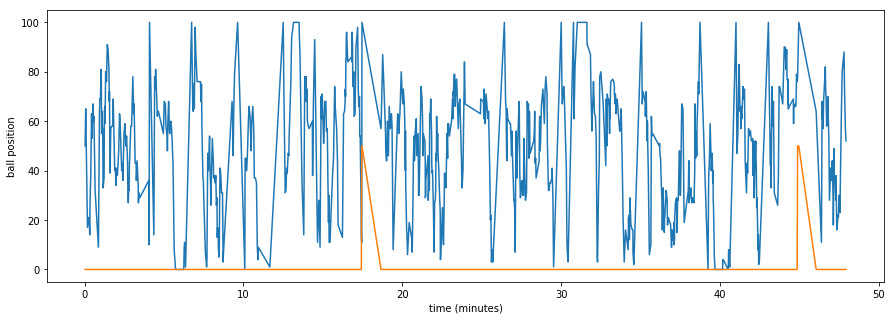

In [1404]:
# Plots the time-series of the x coordinate of the ball for a given match 
K = np.random.randint(0, 600000);
match = events[events.matchId == events.iloc[K]['matchId']]
match = match[match.matchPeriod == '1H']
time = match.eventSec.values; x = match.x_coord.values; y = match.y_coord.values
goals = match.goal; poss = match.possession
matches[matches.wyId == events.iloc[K]['matchId']]
plt.figure(figsize=(15,5))
plt.plot(time/60, x, label='ball position');
plt.plot(time/60, 50*goals, label='goals');
plt.xlabel("time (minutes)"); plt.ylabel("ball position");
#plt.scatter(time[N1:N2]/60, 50*(2*poss[N1:N2]-2), s=0.1, label='poseesion');
matches[matches.wyId == events.iloc[K]['matchId']]

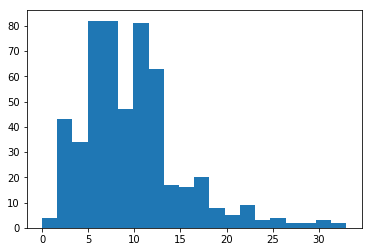

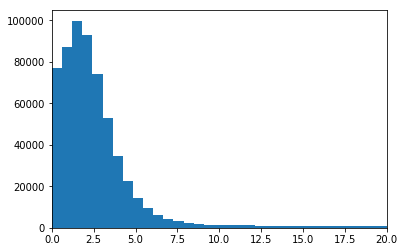

In [1187]:
# plot histogram showing where goals are socred from 
plt.hist(events[(events['goal']==1) & (events['possession']==2) & (events['subEventName']=='Shot')]['x_coord']
         ,bins=20);

# plot histogram showing distirbution of time between events
time_dif = np.diff(events['eventSec'])
time_dif = time_dif[time_dif>0]
plt.figure()
plt.hist(time_dif, bins=1000); plt.xlim([0,20]);

In [1415]:
events[(events["subEventName"]=="Save attempt")]


,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,goal,x_coord,y_coord,possession
250,9,Save attempt,816.923257,177959454,2499719,1H,8480,"[{'y': 100, 'x': 100}, {'y': 49, 'x': 26}]",91,Save attempt,"[{'id': 1205}, {'id': 1801}]",1631,0,0,0,2
1100,9,Save attempt,595.901648,177960312,2499719,2H,7882,"[{'y': 0, 'x': 0}, {'y': 41, 'x': 25}]",91,Save attempt,"[{'id': 1207}, {'id': 1801}]",1609,0,0,0,1
1148,9,Save attempt,825.482751,177960407,2499719,2H,8480,"[{'y': 100, 'x': 100}, {'y': 45, 'x': 23}]",91,Save attempt,"[{'id': 1203}, {'id': 1801}]",1631,0,0,0,2
1335,9,Save attempt,1456.675544,177960576,2499719,2H,8480,"[{'y': 100, 'x': 100}, {'y': 81, 'x': 5}]",91,Save attempt,"[{'id': 1206}, {'id': 1801}]",1631,0,0,0,2
2085,9,Save attempt,998.049534,178147594,2499720,1H,61390,"[{'y': 0, 'x': 0}, {'y': 67, 'x': 24}]",91,Save attempt,"[{'id': 1203}, {'id': 1801}]",1651,0,0,0,1
2486,9,Save attempt,2677.277540,178148042,2499720,1H,71654,"[{'y': 100, 'x': 100}, {'y': 62, 'x': 12}]",91,Save attempt,"[{'id': 1207}, {'id': 1801}]",1625,0,0,0,2
2647,9,Save attempt,302.298018,178148174,2499720,2H,61390,"[{'y': 0, 'x': 0}, {'y': 91, 'x': 11}]",91,Save attempt,"[{'id': 1202}, {'id': 1801}]",1651,0,0,0,1
4301,9,Save attempt,227.176378,178123055,2499721,2H,77502,"[{'y': 100, 'x': 100}, {'y': 77, 'x': 22}]",91,Save attempt,"[{'id': 1208}, {'id': 1801}]",1646,0,100,100,1
4383,9,Save attempt,481.241495,178123159,2499721,2H,77502,"[{'y': 100, 'x': 100}, {'y': 57, 'x': 16}]",91,Save attempt,"[{'id': 1201}, {'id': 1801}]",1646,0,100,100,1
4476,9,Save attempt,952.677222,178123245,2499721,2H,77502,"[{'y': 100, 'x': 100}, {'y': 36, 'x': 28}]",91,Save attempt,"[{'id': 1209}, {'id': 1801}]",1646,0,100,100,1


In [1430]:
# there is a glitch in the data where shots go to the 100,100 or 0,0 coordinate.
# this kinda fixes this as best I can
events["x_coord"] = events["x_coord"].where((events["x_coord"] !=0) | (events["y_coord"]!=0)
                                           | (events["subEventName"]=="Corner"), 0)
events["y_coord"] = events["y_coord"].where((events["x_coord"] !=0) | (events["y_coord"]!=0)
                                           | (events["subEventName"]=="Corner"), 50)
events["y_coord"] = events["y_coord"].where((events["x_coord"] !=100) | (events["y_coord"]!=100)
                                           | (events["subEventName"]=="Corner"), 50)
events["x_coord"] = events["x_coord"].where((events["eventName"] != "Save attempt") 
                                           | (events["possession"] == 1), 100)
events["x_coord"] = events["x_coord"].where((events["eventName"] != "Save attempt") 
                                            | (events["possession"] == 2), 0)
events["y_coord"] = events["y_coord"].where(events["eventName"] != "Save attempt", 50)

In [1463]:
events[(events["x_coord"]==0) & (events["y_coord"]==50)]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,goal,x_coord,y_coord,possession
64,3,Free Kick,196.066859,177959227,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 44, 'x': 28}]",34,Goal kick,[],1609,0,0,50,1
87,4,Goalkeeper leaving line,252.848204,177959250,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 85, 'x': 23}]",40,Goalkeeper leaving line,[],1609,0,0,50,1
92,9,Save attempt,256.547834,177959249,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 48, 'x': 4}]",90,Reflexes,"[{'id': 101}, {'id': 1207}, {'id': 1802}]",1609,1,0,50,1
145,3,Free Kick,517.797223,177959306,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 47, 'x': 24}]",34,Goal kick,[],1609,0,0,50,1
555,9,Save attempt,1712.908250,177959773,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 46, 'x': 6}]",90,Reflexes,"[{'id': 101}, {'id': 1203}, {'id': 1802}]",1609,1,0,50,1
642,3,Free Kick,1986.742257,177959864,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 53, 'x': 45}]",34,Goal kick,[],1609,0,0,50,1
710,3,Free Kick,2203.974174,177959924,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 83, 'x': 26}]",34,Goal kick,[],1609,0,0,50,1
1010,3,Free Kick,346.224552,177960226,2499719,2H,7882,"[{'y': 0, 'x': 0}, {'y': 11, 'x': 35}]",34,Goal kick,[],1609,0,0,50,1
1100,9,Save attempt,595.901648,177960312,2499719,2H,7882,"[{'y': 0, 'x': 0}, {'y': 41, 'x': 25}]",91,Save attempt,"[{'id': 1207}, {'id': 1801}]",1609,0,0,50,1
1108,9,Save attempt,636.247679,177960316,2499719,2H,7882,"[{'y': 0, 'x': 0}, {'y': 46, 'x': 8}]",90,Reflexes,"[{'id': 101}, {'id': 1205}, {'id': 1802}]",1609,1,0,50,1


In [1358]:
events[(events["x_coord"] == 100) & (events["y_coord"]==100)]
events.loc[516].positions[0]['y']

64

### Building the big Markov chain
We assume that the dynamics are described by a discrete time Markov process on the state space 
$$ X = [0,100]^2\times \{1,2\} $$
where the $[0,100]^2$ component describes the position of the ball, and $\{1,2\}$ describes which team has possession of the ball. (Team 1 attacks towards $x=100$ and Team 2 attacks towards $x=0$). We now use our data to estimate the transition probabilities of this process. 

In [1271]:
# function mapping x-y coordinates to discretised integer indexed boxes for Markov chain fitting 
res = 5
num = int(100/res + 2)
def flatten(x, y, poss, res = 5):
    # treat x,y=0 and x,y=100 as separate cases because the ball is out of play
    num = int(100/res + 2)
    x0 = np.where(x == 0, x, x // res + 1)
    y0 = np.where(y == 0, y, y // res + 1)
    
    return  num*x0 + y0 + np.where(poss == 1, 0, 1)*num**2
        
def unflatten(X, res = 5):
    num = int(100/res + 2) 
    poss = np.where(X > num**2-1, 2, 1)
    X = X - (poss - 1)*num**2
    x = np.divmod(X, num )[0]; y = np.divmod(X, num )[1]
    return x, y, poss

unflatten(201)

(9, 3, array(1))

In [1433]:
X = flatten(events['x_coord'], events['y_coord'], events['possession'])
states = np.linspace(0,2*num**2 - 1,2*num**2)
P = dtmc.fitting.fit_walk(fitting_type = 'mle', walk = X,
                         possible_states = states , k = 0)[0]

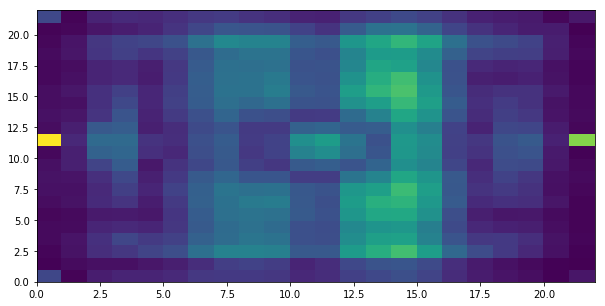

In [1461]:
# Convert each transition function into matrix so it can be visualised
np.sum(P[0,:])
# function plotting the probability of the next events in x,y space, summing over possession
Pn = np.linalg.matrix_power(P,3)
def P_vis(x,y,p):
    k = flatten(x,y,p)
    P_vis = np.zeros((num,num))
    for j in range(len(P)):
        x0,y0,p = unflatten(j)
        P_vis[int(x0), int(y0)] += Pn[k,j]
    return P_vis

# function plotting the probability of dispossesion as a function of x,y
def P_pos(p, p_bar):
    P_pos = np.zeros((num,num))
    for i in range(len(P)):
        x0, y0, p0 = unflatten(i)
        for j in range(len(P)):
            x1, y1, p1 = unflatten(j)
            if (p0 == p) and (p1 == p_bar):
                P_pos[int(x0), int(y0)] += P[i,j]
    return P_pos

        
plt.figure(figsize=(10,5))
plt.pcolor(P_vis(100,50,1).T);
#plt.figure(figsize=(10,5))
#plt.pcolor(P_pos(2,2).T);
#np.max(P_pos(2,2))

In [454]:
# Testing the use of py.dtmc library functions
P1 = np.array([[0.3, 0.0, 0.7], 
              [0.1, 0.7, 0.2],
              [0.0, 0.5, 0.5]])
X1 = dtmc.MarkovChain(P1)
x1 = [1,1,2,0,1,2,2,1,1,0]
Y1 = dtmc.fitting.fit_walk(fitting_type = 'mle', possible_states = ['0','1','2'], walk = x1, k=0)
Y1 = dtmc.MarkovChain(Y1[0], ['1','2','Ge'] )

def S_N(N):
    S_N = []
    for i in range(N):
        S_N.append(str(i))
    return S_N
S_N(10)



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [456]:
# Map event data to numerical data so that it can be fitted to Markov chain 
events_labelled = events.subEventName.values
i = 0
for l in events.subEventName.unique():
    events_labelled = np.where(events.subEventName.values == l, i, events_labelled)
    i = i+1

In [462]:
events.subEventName.unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Late card foul', 'Out of game foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

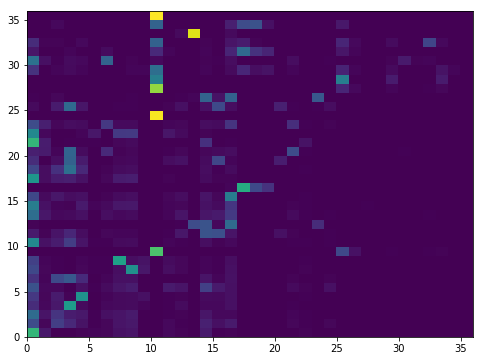

In [464]:
P = dtmc.fitting.fit_walk(fitting_type = 'mle', walk = events_labelled,
                          possible_states = events.subEventName.unique(), k = 0)[0]
plt.figure(figsize=(8, 6))
plt.pcolor(P)

### A constructive model 
So far we have estimated the transition probabilities of the Markov process by discreting the state space and empircally estimating the transition probabiities from the data. We can also propose a parameterised form of these transition probabilities based on our knowledge of the game, and then try to estimate these parameters. A simple model could be given by 
$$ \begin{pmatrix} x_{n+1} \\ y_{n+1} \end{pmatrix} = \begin{pmatrix} x_n \\ y_n \end{pmatrix} + \alpha\left(\mathrm{Goal}(P_n) - \begin{pmatrix} x_n \\ y_n \end{pmatrix}\right) + \sigma \begin{pmatrix} \xi_n^1\\ \xi_n^2 \end{pmatrix}  $$
where $\mathrm{Goal}(P)$ gives the position of the goal that team $P$ is attacking, $\alpha,\sigma>0, $ are two parameters to be estimated and $(\xi_n^1,\xi_n^2)$ are a sequence of i.i.d. (say normally distributed) random variables. When a team has the ball they try to get it closer to their opponent's goal. 

In [1482]:
small_events = events.iloc[0:1000,:]
small_events.pop('eventName')
small_events.pop('subEventName')

0                 Simple pass
1                   High pass
2                   Head pass
3                   Head pass
4                 Simple pass
5                 Simple pass
6                   Head pass
7                    Air duel
8                    Air duel
9                   Head pass
10                  Head pass
11                  High pass
12                   Air duel
13                   Air duel
14                  High pass
15                  Head pass
16                  Head pass
17                Simple pass
18                Simple pass
19                  High pass
20                  Head pass
21                  Head pass
22     Ground loose ball duel
23     Ground loose ball duel
24                 Smart pass
25                Simple pass
26                     Launch
27                   Air duel
28                   Air duel
29      Ground defending duel
                ...          
970               Simple pass
971               Simple pass
972       

In [1493]:
def f(x):
    return x + 2
small_events['subEventId'].apply(f)

TypeError: must be str, not int

In [1516]:
arr = [1,2,3,4,5,6,7,8,9]
arr1 = [np.sin(x) if (x % 2 == 0 and x > 1) else 300 for x in arr]

In [1517]:
arr1

[300,
 0.9092974268256817,
 300,
 -0.7568024953079282,
 300,
 -0.27941549819892586,
 300,
 0.9893582466233818,
 300]

In [1502]:
3 // 2

1

In [1503]:
4 // 2

2